Inspired by genomic. Radiomics : extraction and analysis of quantitative features fro medical images. IBSI v1 ~= 170, 3 major categories : First order, texture, shape

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
D = np.load("C:/Users/HP/OneDrive/Documents/Study/AI/AIclass/mnist.npz")
trn_lbls = D["train_labels"][::10] # just use 10% data
trn_imgs = D["train_imgs"][::10]
idx = trn_lbls <= 1
lbls = trn_lbls[idx]
imgs = trn_imgs[idx]

In [ ]:
import SimpleITK as sitk #image processing library
from radiomics import featureextractor

extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.disableAllFeatures()
extractor.enableFeatureClassByName("shape2D") #calculate the 2D shape features

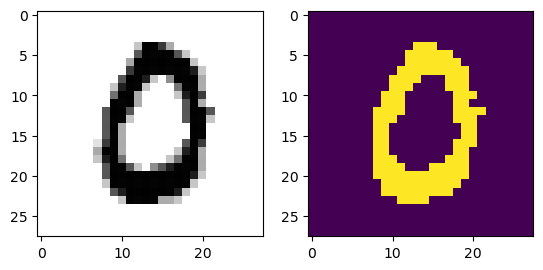

In [5]:
img = imgs[8]
msk = img < 128
_, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.imshow(img, cmap = "gray")
ax2.imshow(msk)

In [6]:
im = sitk.GetImageFromArray(img)
bw = sitk.GetImageFromArray(msk.astype(np.uint8))
d_features = extractor.execute(im, bw)
for k in d_features.keys(): #nine 2D shapes features
    print(k)

diagnostics_Versions_PyRadiomics
diagnostics_Versions_Numpy
diagnostics_Versions_SimpleITK
diagnostics_Versions_PyWavelet
diagnostics_Versions_Python
diagnostics_Configuration_Settings
diagnostics_Configuration_EnabledImageTypes
diagnostics_Image-original_Hash
diagnostics_Image-original_Dimensionality
diagnostics_Image-original_Spacing
diagnostics_Image-original_Size
diagnostics_Image-original_Mean
diagnostics_Image-original_Minimum
diagnostics_Image-original_Maximum
diagnostics_Mask-original_Hash
diagnostics_Mask-original_Spacing
diagnostics_Mask-original_Size
diagnostics_Mask-original_BoundingBox
diagnostics_Mask-original_VoxelNum
diagnostics_Mask-original_VolumeNum
diagnostics_Mask-original_CenterOfMassIndex
diagnostics_Mask-original_CenterOfMass
original_shape2D_Elongation
original_shape2D_MajorAxisLength
original_shape2D_MaximumDiameter
original_shape2D_MeshSurface
original_shape2D_MinorAxisLength
original_shape2D_Perimeter
original_shape2D_PerimeterSurfaceRatio
original_shape2D_P

In [7]:
px_surf = d_features["original_shape2D_PixelSurface"]
print(px_surf) #pixel in ROI surface by the surfave of a singel pixel
print(np.sum(msk))

130.0
130


In [8]:
perim = d_features["original_shape2D_Perimeter"]
print(perim)
print(55.456 + 31.556)

92.66904755831222
87.012


In [9]:
print(d_features["original_shape2D_PerimeterSurfaceRatio"])
print(perim / px_surf)

0.7128388273716324
0.7128388273716324


In [10]:
print(d_features["original_shape2D_Sphericity"])
r = np.sqrt(px_surf / np.pi)
print(2*np.pi*r /perim)

0.4361560577501651
0.4361560577501651


In [12]:
from tqdm import tqdm

sz = lbls.size
feats = np.zeros([sz, 9])
for n in tqdm(range(sz)):
    im = imgs[n]
    bw = sitk.GetImageFromArray((im<128).astype(np.uint8))
    im = sitk.GetImageFromArray(im)
    d_feats = extractor.execute(im, bw)
    feats[n] = [
        d_feats["original_shape2D_Elongation"],
        d_feats["original_shape2D_MajorAxisLength"],
        d_feats["original_shape2D_MaximumDiameter"],
        d_feats["original_shape2D_MeshSurface"],
        d_feats["original_shape2D_MinorAxisLength"],
        d_feats["original_shape2D_Perimeter"],
        d_feats["original_shape2D_PerimeterSurfaceRatio"],
        d_feats["original_shape2D_PixelSurface"],
        d_feats["original_shape2D_Sphericity"],
    ]

100%|██████████| 1205/1205 [00:40<00:00, 30.09it/s]


In [13]:
print(feats[0])

[ 0.15693005 22.23592891 20.09975124 58.5         3.48948534 45.3137085
  0.77459331 59.          0.59834719]


In [21]:
mn = np.mean(feats, axis = 0)
sd = np.std(feats, axis = 0)
zfeats = (feats - mn)/ sd

def model(w, b, x):
    val = (x @ w + b).flatten()
    return 1/(1 + np.exp(-val))
def loss(lbls, preds):
    return np.mean(np.square(lbls -preds))
def mdl_loss(lbls, w, b, x):
    return loss(lbls, model(w, b, x))
def calc_acc(lbls, preds):
    acc = (lbls == 1) == (preds > 0.5)
    return np.sum(acc) / lbls.size * 100


In [23]:
sz_ft = 9
w, b = np.ones(shape=[sz_ft]), 0
delta = 1e-9
lrn_rate = 1e-2
losses = np.zeros(2000)
accuracies = np.zeros(losses.size)
for n in tqdm(range(losses.size)):
    lv = mdl_loss(lbls, w, b, zfeats)
    w_grad = np.zeros(shape=[sz_ft, 1])
    for n_f in range(sz_ft):
        wx = np.copy(w)
        wx[n_f] += delta
        w_grad[n_f] = (mdl_loss(lbls, wx, b, zfeats) - lv) / delta
    b_grad = (mdl_loss(lbls, w, b+delta, zfeats) - lv)/delta
    w = w - w_grad.flatten() * lrn_rate
    b = b - b_grad * lrn_rate
    losses[n] = lv
    accuracies[n] = calc_acc(lbls, model(w,b,zfeats))
print([lv, accuracies[-1]])
print([w.flatten(),b])

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:11<00:00, 179.08it/s]

[0.015777362642682764, 98.42323651452281]
[array([-0.31834254,  0.30409295,  0.42243738, -0.13717776, -0.31822132,
       -0.37360128,  1.11707324, -0.13662609,  2.17314091]), 0.16463390716675574]


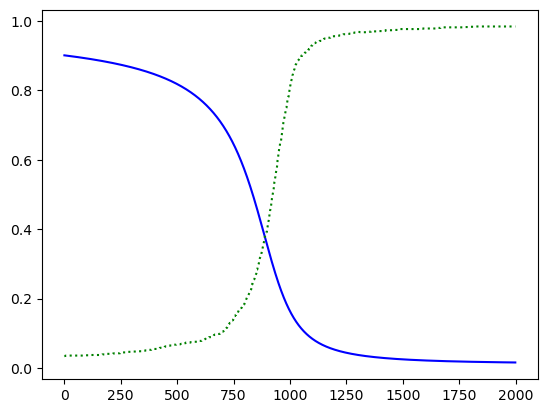

In [24]:
_, ax = plt.subplots()
ax.plot(losses, 'b-')
ax.plot(accuracies / 100, 'g:')

In [25]:
rng = np.random.default_rng(0)
preds = rng.uniform(size= lbls.shape)
print(calc_acc(lbls, preds))

52.199170124481334
